# OpenVINO Detection Models

This repository comes with a companion Docker image required to run this notebook. Follow the instructions on (ADD_LINK) to get your Docker image running in few simple steps.

If your environment is setup propertly, you should expect to see the OpenVINO's version after executing the cell below.

In [1]:
from openvino import inference_engine as ie

print('openvino inference engine:', ie.__version__)

openvino inference engine: 2.1.37988


## Import dependencies

In [2]:
import os
import sys
import time
import logging as log
import numpy as np
import tensorflow as tf
import cv2 as cv

# from tensorflow.gfile import GFile
from IPython.display import Image
from IPython.display import HTML
from utils import parse_od_output, draw_image
from openvino import inference_engine as ie
from openvino.inference_engine import IECore
from openvino.inference_engine import IENetwork


# path to test images
TEST_DATA_PATH = os.path.join('.','data')

print('tensorflow:', tf.__version__)
print('openvino ie:', ie.__version__)
print('numpy:', np.__version__)

tensorflow: 1.15.0
openvino ie: 2.1.37988
numpy: 1.17.0


## Detect Faces

The model input is a blob that consists of a single image of ``1x3x384x672`` in the RGB order.

The model output is a typical vector containing the tracked object data. Note that the ``class_id`` data is now significant and should be used to determine the classification for any detected object.

Model outputs:

1. Classifier, name - detection_classes, contains predicted bounding boxes classes in range [1, 91]. The model was trained with 90 categories of objects.

2. Probability, name - detection_scores, contains probability of detected bounding boxes.

3. Detection box, name - detection_boxes, contains detection boxes coordinates in format [y_min, x_min, y_max, x_max], where (x_min, y_min) are coordinates top left corner, (x_max, y_max) are coordinates of the right bottom corner. Coordinates are rescaled to the input image size.

4. Detections number, name - num_detections, contains the number of predicted detection boxes.

## Config

In [3]:
TEST_DATA_PATH = os.path.join('.', 'data')
FACE_ASSETS = os.path.join(TEST_DATA_PATH, 'intel', 'face-detection-adas-0001')
MODEL_PATH_XML = os.path.join(FACE_ASSETS, 'FP32', 'face-detection-adas-0001.xml')
MODEL_PATH_BIN = os.path.join(FACE_ASSETS, 'FP32', 'face-detection-adas-0001.bin')
DEVICE = 'CPU'
IMAGES_PATH = os.path.join(TEST_DATA_PATH, 'images')
INPUT_IMAGE = os.path.join(IMAGES_PATH, 'input', 'person1.jpg')
OUTPUT_IMAGE = os.path.join(IMAGES_PATH, 'output', 'person1.jpg')

### Step 1: Download the model

We are interested on the ``face-detection-adas-0001`` model.

In [4]:
!python ${INTEL_OPENVINO_DIR}/deployment_tools/open_model_zoo/tools/downloader/downloader.py --print_all | grep face-detection-adas-0001

face-detection-adas-0001


Download the model under the ``./data`` folder.

In [5]:
!python ${INTEL_OPENVINO_DIR}/deployment_tools/open_model_zoo/tools/downloader/downloader.py \
--name face-detection-adas-0001 \
--output_dir ./data

################|| Downloading models ||################

========== Downloading data/intel/face-detection-adas-0001/FP32/face-detection-adas-0001.xml
... 100%, 227 KB, 5015 KB/s, 0 seconds passed

========== Downloading data/intel/face-detection-adas-0001/FP32/face-detection-adas-0001.bin
... 100%, 4113 KB, 13898 KB/s, 0 seconds passed

========== Downloading data/intel/face-detection-adas-0001/FP16/face-detection-adas-0001.xml
... 100%, 227 KB, 7450 KB/s, 0 seconds passed

========== Downloading data/intel/face-detection-adas-0001/FP16/face-detection-adas-0001.bin
... 100%, 2056 KB, 16124 KB/s, 0 seconds passed

========== Downloading data/intel/face-detection-adas-0001/FP32-INT8/face-detection-adas-0001.xml
... 100%, 492 KB, 12041 KB/s, 0 seconds passed

========== Downloading data/intel/face-detection-adas-0001/FP32-INT8/face-detection-adas-0001.bin
... 100%, 4190 KB, 15422 KB/s, 0 seconds passed

################|| Post-processing ||################



### Step 1. Instantiate the entitiy that helps us manupulate plugins using unified interfaces

In [6]:
ie = IECore()

### Step 2. Read and prepare the model

The IENetwork class is designed to work with a model in the Inference Engine. This class contains information about the network model read from the intermediate representation and allows you to manipulate some model parameters such as layers affinity and output layers.

In [7]:
net = IENetwork(MODEL_PATH_XML, MODEL_PATH_BIN)

### Step 3. Get the name of the input layer of the model

To infer a model, you need to know input layers of the model. The object ```net``` contains information about inputs of the network in a property named ```inputs``` which is a dictionary. 

- key - name of the input layer
- volume - representation of the input.

In [8]:
input_blob = next(iter(net.inputs))

print(f'Input layer of the network is: {input_blob}')

Input layer of the network is: data


### Step 4: Get shape (dimensions) fo the input layer of the network

- n: number of batches
- c: number of input image channels (usualy 3 for RGB)
- h: height
- w: width

In [9]:
n, c, h, w = net.inputs[input_blob].shape

print(f'Input shape of the network: [{n}, {c}, {h}, {w}]')

Input shape of the network: [1, 3, 384, 672]


### Step 5: Get names of output layers of the network

In [10]:
out_blob = next(iter(net.outputs))

print(f'Output layer of the network: {out_blob}')

Output layer of the network: detection_out


### Step 6: Load the network to a device

- ```network```: instance of IENetwork
- ```device_name```: contains a divice name to infer a model on: CPU, GPU, FPGA, etc.


In [11]:
net = ie.load_network(network=net, device_name=DEVICE)

### Step 7: Open the input video

In [12]:
def read_resize_image(path_to_image: str, width: int, height: int):
    """
    Takes an image and resizes it to the given dimensions.
    """
    # Load the image 
    raw_image = cv.imread(path_to_image)
    # Return the image resized to the (width, height) format
    return cv.resize(raw_image, (width, height), interpolation=cv.INTER_NEAREST)

In [13]:
image = read_resize_image(INPUT_IMAGE, w, h)
image.shape

(384, 672, 3)

### Step 8: Perfom inference

In [14]:
image = image[..., ::-1]
in_frame = image.transpose((2, 0, 1))
batched_frame = in_frame.reshape(1, c, h, w)
res = net.infer(inputs={input_blob: batched_frame})

Detected face #1

In [15]:
res[out_blob][0][0][0]

array([0.        , 1.        , 0.9999999 , 0.38031176, 0.23423073,
       0.4688119 , 0.31727698], dtype=float32)

Detected face #2

In [16]:
res[out_blob][0][0][1]

array([0.        , 1.        , 0.9970266 , 0.62545276, 0.22033837,
       0.7074003 , 0.2948102 ], dtype=float32)

### Step 9: Function for processing inference results

- element 0: batch ID
- element 1: class ID
- element 2: the confidence for the object
- element 3 and 4: coordinates of the upper-left corner of the bounding box
- element 5 and 6: coordinates of the botton-right corner of the bounding box

In [17]:
from typing import Any
from typing import Dict
from typing import List

threshold = 0.0001

def draw_boxes_in_frame(obj: List[float], frame_w: int, frame_h: int, labels_map: Dict[str, str], frame: Any) -> None:
    batch_id, class_id, confidence, xmin, ymin, xmax, ymax = obj
    if confidence > threshold:
        xmin = int(xmin * frame_w)
        ymin = int(ymin * frame_h)
        xmax = int(xmax * frame_w)
        ymax = int(ymax * frame_h)
        class_id = int(class_id)
        confidence = round(confidence * 100, 1)
        log.debug(f'Estimated class: {confidence}')
        log.debug(f'x,y min: {xmin, ymin} - x,y max: {xmax, ymax}')
        color = (min(class_id * 12.5, 255), min(class_id * 7, 255), min(class_id * 5, 255))
        cv.rectangle(frame, (xmin, ymin), (xmax, ymax), color, 2)
        label = labels_map[class_id]
        text = f'{label}: {confidence}'
        cv.putText(frame, text, (xmin, ymin - 7), cv.FONT_HERSHEY_COMPLEX, 2, color, 2)

### Step 10: Showing bounding predictions

In [18]:
def draw_image(original_image: str, res: tuple, output_image: str,
              prob_threshold: float=0.8, color: tuple=(255, 0, 0)):
    """
    Takes a path to the image and bounding boxes.
    Draws those boxes on the new image and saves it.
    """
    raw_image = cv.imread(original_image)
    initial_h, initial_w, _ = raw_image.shape
    for obj in res[0][0]:
        ignore, class_id, prob, xmin, ymin, xmax, ymax = obj  
        log.debug(f'Bound box probability: {prob}')
        if prob > prob_threshold:
            xmin = int(xmin * initial_w)
            ymin = int(ymin * initial_h)
            xmax = int(xmax * initial_w)
            ymax = int(ymax * initial_h)
            log.debug(f'Estimated class: {prob}')
            log.debug(f'x,y min: {xmin, ymin} - x,y max: {xmax, ymax}')
            cv.rectangle(raw_image, (xmin, ymin), (xmax, ymax), color, 2)
    cv.imwrite(output_image, raw_image)

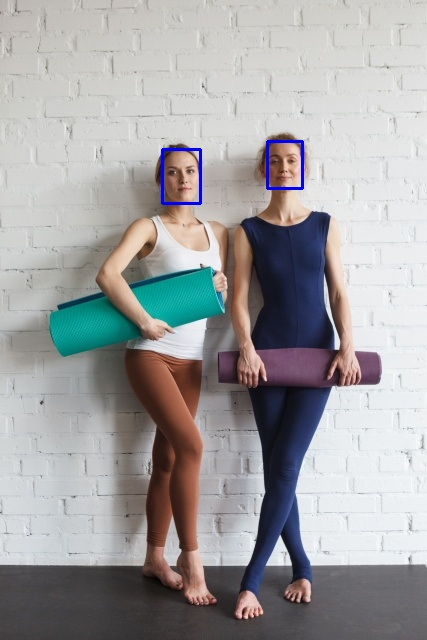

In [19]:
draw_image(INPUT_IMAGE, res[out_blob], OUTPUT_IMAGE)
Image(filename=OUTPUT_IMAGE)